In [33]:
%%shell
jupyter nbconvert --to html /content/hito2_minDatos.ipynb --no-input --no-prompt

[NbConvertApp] Converting notebook /content/hito2_minDatos.ipynb to html
[NbConvertApp] Writing 1087692 bytes to /content/hito2_minDatos.html


# **Informe Grupo 6 Sección Hito 1 - "Steam Videogames Analysis"**

**Integrantes del Grupo:** Cristóbal Braga, Isabel Marx, Iván Salas, Manuel Ortiz y Sofia Medina

### **Introducción**

En un mundo donde la tecnología y la innovación están en constante evolución, la industria de los videojuegos emerge como uno de los sectores más dinámicos y prometedores. Según el informe Gaming & Esports Report 2023 de YouGov, un 31% de la población mundial se dedica activamente a jugar videojuegos en diversas plataformas, ya sea en PC, consolas o dispositivos móviles, durante una semana típica. Este dato por sí solo pone de manifiesto la popularidad y el alcance de esta forma de entretenimiento. Dentro de este panorama, Steam, la plataforma de distribución digital de videojuegos desarrollada por Valve Corporation, juega un papel fundamental. Lo que comenzó en septiembre de 2003 como un medio para que Valve proporcionara actualizaciones automáticas a sus propios juegos ha evolucionado a lo largo de los años hasta convertirse en una plataforma donde coexisten desde desarrolladores independientes hasta grandes corporaciones de software, lo que brinda a los jugadores una variedad sorprendente de opciones. Este fenómeno plantea una pregunta crucial: ¿qué hace que un juego sea exitoso en un mercado tan diverso y competitivo? El estudio del comportamiento de plataformas como Steam proporciona información sobre las tendencias y las estrategias que pueden llevar a un juego al éxito en este entorno digital en constante expansión.

In [ ]:
# PREPROCESAMIENTO DEL DATASET
# standard library imports
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive/')
df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

def remove_non_english(df):
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()

    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]

    # remove english column, now redundant
    df = df.drop('english', axis=1)

    return df

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews

    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])

    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]

    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)

        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

    # repeat for genre column names (get_unique used to find unique genre names,
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])

    # only keeping 'main' genres similar to steam store
    gen_cols = ['Action','Adventure','Casual','Indie','Massively Multiplayer',
                'RPG','Racing','Simulation','Sports','Strategy']

    gen_col_names = []

    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)

        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)

    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()

    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])

    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    # [optional] remove 'genres column'
    #df = df.drop('genres',axis=1)

    return df

def pre_process(df):
    # keep english only
    df = remove_non_english(df)

    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()

    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)

    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)

    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)

    return df

# Process data
data = pre_process(df_steam)
data.head()


### **Análisis Exploratorio de Datos**
Con respecto a la motivación mencionada anteriormente, se ha seleccionado el conjunto de datos “Steam Store Games” de la página web Kaggle. Este conjunto de datos contiene información recopilada en mayo de 2019 sobre videojuegos de la plataforma Steam y está compuesto por 6 archivos:

*   steam.csv
*   steam_description_data.csv
*   steam_media_data.csv
*   steam_requirements_data.csv
*   steam_support_info.csv
*   steamspy_tag_data.csv

Para los propósitos iniciales del proyecto, se utilizará el archivo principal, steam.csv, aunque no se descarta la posibilidad de utilizar datos de otros archivos según los requisitos futuros del proyecto. A continuación, se presenta un resumen del análisis exploratorio inicial de los datos contenidos en steam.csv, que consta de 18 columnas diferentes.


  1. “appid” (int), identificador (llave) de cada juego, los valores van desde 10 a 1.069.460, también se comprueba que efectivamente los id sean únicos, al comparar el largo de los valores únicos de la columna con el largo original.
  
  2. “name” (char), nombre de cada juego, en este atributo se puede notar que hay 41 names repetidos, siendo “Dark Matter” el nombre con más repeticiones (hay tres juegos de distintos estudios con el nombre “Dark Matter”)

  3. “release_date” (char), fecha de lanzamiento de cada juego, en formato YYYY-MM-DD. Es importante notar que el 75% de las tuplas (del primer al último cuartil) están concentradas desde el 2016 al 2019, es decir los últimos tres años del dataset contienen la mayor información.

  4. “english” (int), variable binaria que indica si un juego está en inglés o no, en síntesis un 98,11% de los juegos del dataset están en inglés y solo un 1,88% está en otro idioma.

  5. “developer” (char), nombre(s) del desarrollador de cada juego. Hay 17.112 distintos, lo que sugiere una gran diversidad de desarrolladores. De estos, los 5 que más se repiten son: Choice of Games (94), KOEI TECMO GAMES CO., LTD. (72), Ripknot Systems (62), Laush Dmitriy Sergeevich (51) y Nikita “Ghost_RUS” (50).

  6. “publisher” (char), como en la columna anterior, hay una gran cantidad de publishers distintos. Hay 14.354 publishers únicos y los que más se repiten son: Big Fish Games (212), Strategy First (136), Ubisoft (111), THQ Nordic (98), Square Enix (97).

  7. “platforms” (char), plataformas en la/s que corre cada juego. De los 7 distintos posibles valores de tuplas que hay en esta columna Windows está presente en 4 alternativas, lo que implica que de los 27.075
  juegos distintos 27.070 funcionan con Windows, es decir el 99,98% de los juegos corren en Windows.

  8. “required_age” (int), edad mínima para jugar cada juego. Hay 6 valores distintos (0,3,7,12,16 y 18). La mayoría (97,79%) de los juegos tienen como edad mínima 0.
  
  9. “categories” (char), categorías de cada juego, contiene 29 categorías distintas, siendo “Single-player” la más popular con 25.678 menciones.

  10. “genres” (char), géneros de cada juego y hay 29 distintos. El más popular es “Indie” con 19.421 menciones, es decir el 71,73% de los juegos son mencionados como “Indie”. Cada juego puede tener más de un género a la vez.

  11. “steamspy_tags” (char), es similar a genres pero votada por la comunidad. Aquí hay más etiquetas que en la columna anterior (339 distintas), sin embargo “Indie” sigue siendo la mención más frecuente, esta vez en el 60% de los juegos. Las 5 más frecuentes además de Indie son Action, Casual, Adventure y
  Strategy.

  12. “achievements” (int), cantidad de logros de cada juego. El máximo es 9.821, sin embargo la mediana es igual a 7, y el tercer cuartil igual a 23, es decir, la mayoría de los juegos tienen pocos o ningún logro
  (11.864 juegos con 0 logros).

  13. “positive_ratings” (int), cantidad de calificaciones positivas de cada juego. En esta columna se puede notar que el 75% están entre 0 y 126 positive reviews, pero el máximo es 2.644.404, lo cual implica que juegos con un alto número de valoraciones son casos extremos. La media de calificaciones positivas es 1.000,559 y su desviación estándar 18.988,72 .

  14. “negative_ratings” (int), cantidad de calificaciones negativas de cada juego. Similar a la anterior, la mayoría de los juegos tienen pocas reviews, teniendo el 75% entre 0 y 42 negative reviews. El valor máximo de negative reviews que tiene un juego es 487,076. La media de calificaciones negativas es
  211,0271 y su desviación estándar 4.284,939.

  15. “average_playtime” (int), cantidad de horas jugadas promedio de cada juego. Solo 6.170 juegos tienen valor distinto de 0, es decir, el 22,78%, y por ende el 77,21% de los juegos tienen tiempo promedio igual a 0.

  16. “median_playtime” (int), tiempo medio de juego. En este caso solo hay 6.170 juegos con un tiempo distinto de 0.

  17. “owners” (char), rangos de cantidad de personas que poseen cada juego. Para este análisis se tomó el punto medio del intervalo que se presenta en el dataset en la columna, de esa forma se tiene que el 75% tienen un número de owners entre 10.000 y 35.000.

  18. “price” (double con 2 decimales), precio de cada juego en su salida. El 75% de los juegos tienen un valor entre 0 y 7.190 GBP, además hay 2.560 juegos gratis.


Habiendo resumido las columnas, se presenta a continuación cómo se correlacionan entre sí. Las correlaciones entre atributos más destacadas son positivas y se dan entre los siguientes atributos: positive_ratings/negative_ratings, average_playtime/median_playtime, owners_midpoint/positive_rankig y owners_midpoint/negative ratings.

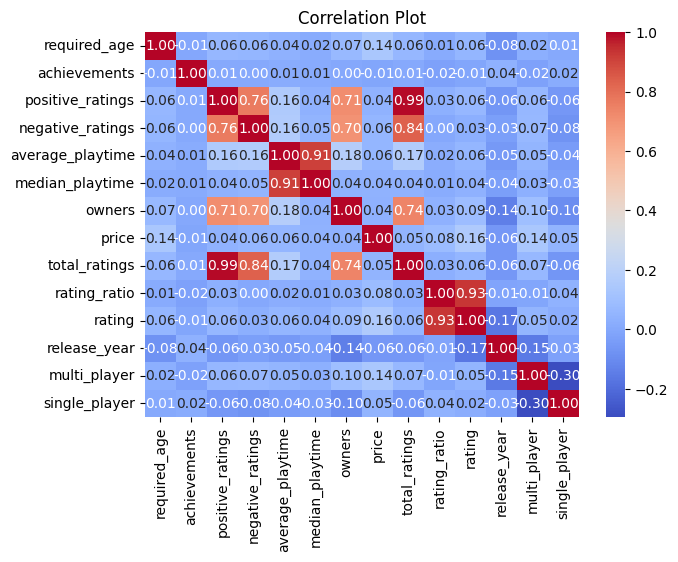

In [5]:
# List of columns to exclude and convert to lowercase
gen_cols = ['appid','action','adventure','casual','indie','massively_multiplayer','rpg','racing','simulation','sports','strategy']

# Filter numeric columns in the DataFrame, excluding the specified columns
columnas_numericas = data.select_dtypes(include=[np.number]).drop(columns=gen_cols)

# Calculate the correlation matrix
matriz_correlacion = columnas_numericas.corr()

# Create a correlation plot using Seaborn
plt.figure(figsize=(7, 5))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Plot")
plt.show()


### **Gráficos**

A continuación se presenta la sección de gráficos del informe, en el cual se han graficado variables interesantes para los propositos del proyecto.

En la siguiente gráfica se observa que alrededor de 17.500 juegos tienen 0 owners, es decir hay muchos juegos con pocos owners y pocos juegos con muchos owners.

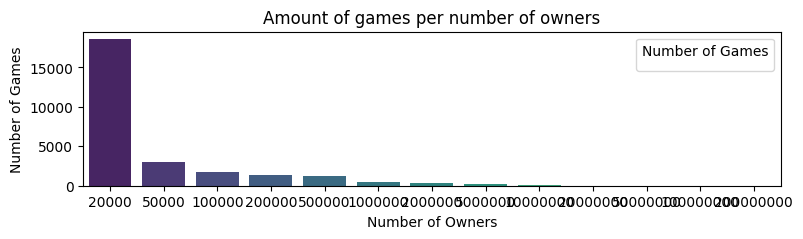

In [41]:
# Grafica Amount of games per number of owners
# Group and aggregate the data
agg_own = df.groupby('owners_upper').size().reset_index(name='total_count')
agg_own = agg_own.sort_values(by='total_count', ascending=True)

# Create the plot
plt.figure(figsize=(9, 2))
ax = sns.barplot(x='owners_upper', y='total_count', data=agg_own, palette="viridis")
plt.title("Amount of games per number of owners")
plt.xlabel("Number of Owners")
plt.ylabel("Number of Games")
plt.legend([], title="Number of Games")
plt.show()

Se observa que los últimos años es cuando se lanzaron más juegos, siendo 2018 el año en que más se lanzaron, con más de 8.000.

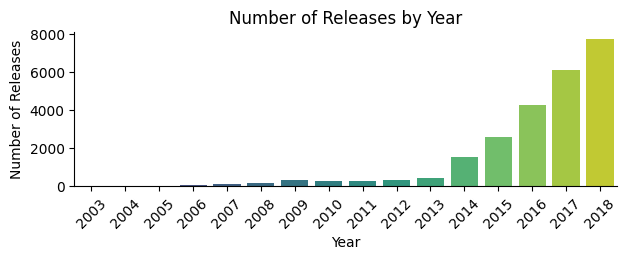

In [39]:
data2 = data[(data['release_year'] >= 2003) & (data['release_year'] <= 2018)]
years = sorted(data2['release_year'].unique())
release_counts = data2['release_year'].value_counts().sort_index()

plt.figure(figsize=(7, 2))
ax = sns.barplot(x=years, y=release_counts, palette='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of Releases by Year')
plt.xticks(rotation=45)
sns.despine()
plt.show()

En la siguiente gráfica se puede apreciar las valoraciones positivas y negativas de un subset de juegos famosos.

<Figure size 600x400 with 0 Axes>

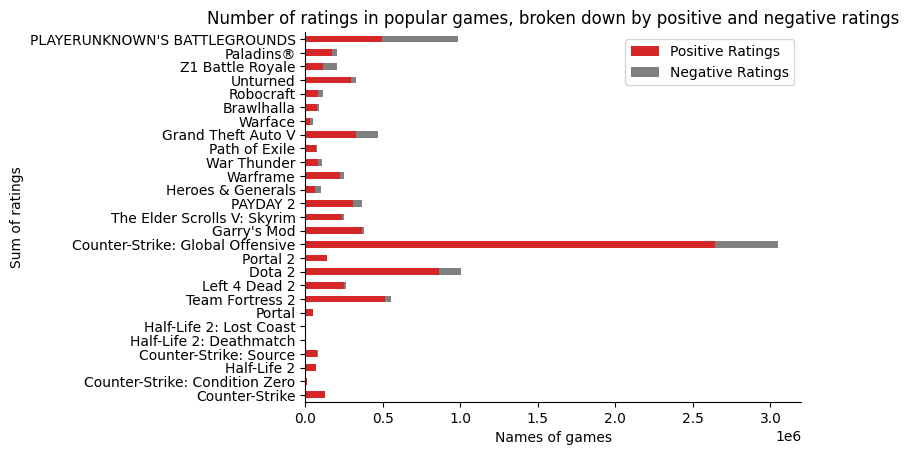

In [38]:
# Calculate 'owners_n' as unique values sorted
owners_n = sorted(df['owners_upper'].unique())

# Filter 'steam' to include rows where 'owners_mid_bound' is greater than or equal to the 10th value in 'owners_n'
agg_own = df[df['owners_upper'] >= owners_n[9]]

ratings = agg_own['positive_ratings'] + agg_own['negative_ratings']

df1 = pd.DataFrame({
    'Name': agg_own['name'],
    'Positive Ratings': agg_own['positive_ratings'],
    'Negative Ratings': agg_own['negative_ratings'],
    'Ratings': ratings,
    'Owners': agg_own['owners_upper'],
    'Price': agg_own['price']
})

owners_df = pd.DataFrame(zip(df1['Name'], df1['Positive Ratings'], df1['Negative Ratings']),
                         columns=['Name', 'Positive Ratings', 'Negative Ratings'])

plt.figure(figsize=(6, 4))
ax = df1.plot(x='Name', y=['Positive Ratings', 'Negative Ratings'], kind='barh', stacked=True, color=['tab:red', 'gray'])

ax.set_ylabel('Sum of ratings')
ax.set_xlabel('Names of games')
ax.set_title('Number of ratings in popular games, broken down by positive and negative ratings')
sns.despine()
plt.show()

Del subset de juegos populares escogidos se presenta el precio en el eje X, y el nombre del juego en el eje y, mientras que el largo de la barra representa el precio de cada juego.

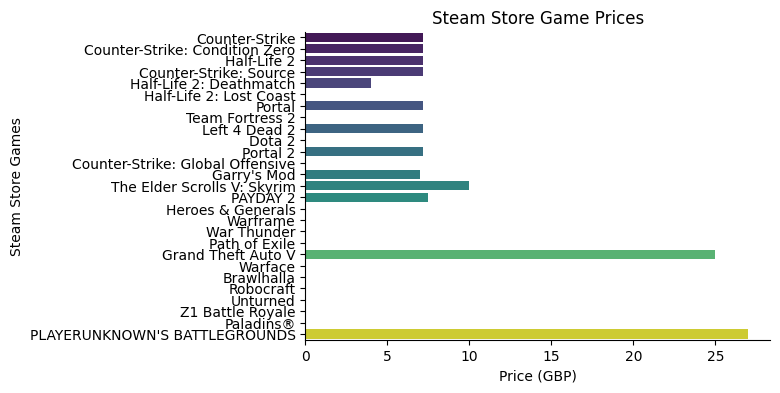

In [37]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Price', y='Name', data=df1, palette='viridis')

ax.set_xlabel('Price (GBP)')
ax.set_ylabel('Steam Store Games')
ax.set_title('Steam Store Game Prices')
plt.xticks(rotation=0)  # Do not rotate x-axis labels
sns.despine()
plt.show()

En la siguiente gráfica se muestran las categorias de juegos más populares.

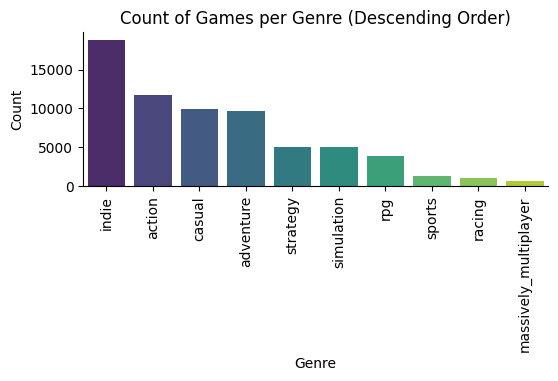

In [19]:
gen_cols = [
    'action',
    'adventure',
    'casual',
    'indie',
    'massively_multiplayer',
    'rpg',
    'racing',
    'simulation',
    'sports',
    'strategy'
]

# Subset the DataFrame to include only the binary genre columns
genre_data = data[gen_cols]

# Calculate the count of games for each genre
genre_counts = genre_data.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']

# Sort the DataFrame by Count in descending order
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(6, 2))
ax = sns.barplot(x='Genre', y='Count', data=genre_counts, palette='viridis')

ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Count of Games per Genre (Descending Order)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
sns.despine()
plt.show()

### **Preguntas y problemas**

En base al análisis exploratorio de los datos hecho previamente se definen los siguientes problemas y preguntas a resolver utilizando este dataset: ¿Qué es lo que hace que un juego sea bueno?, ¿Cuál es el atributo más importante que define a un juego bueno? ¿su positive/negative ratio, su ganancia, su número de jugadores o su tiempo de juego? (esto nos podría generar un problema con el fenómeno del "review bombing") ¿Hay algún patrón que identifique a los mejores juegos? ¿Hay algún género que sea más exitoso que otros, hay una trama en común en los juegos exitosos?, ¿Hay algún/os atributo/s que permitan predecir si un juego será exitoso o no?

En base a las preguntas anteriores, ¿Se puede hacer un modelo que prediga si un juego con ciertas características será exitoso o no? ¿Con qué certeza se podría hacer esta predicción?

Para determinar qué hace que un juego sea bueno, se puede hacer un análisis de correlación entre las métricas de éxito de un juego, como el positive/negative ratio, ganancia, número de jugadores y tiempo de juego, y las calificaciones o reseñas de los usuarios. Un modelo de regresión podría ser útil para identificar el atributo más influyente en la calidad del juego. Para identificar patrones en los mejores juegos, se pueden utilizar técnicas de clustering para agrupar juegos en categorías similares en función de atributos como género, trama, y otras características relevantes. Posteriormente, se podría realizar un análisis comparativo entre los clusters para identificar tendencias comunes en los juegos exitosos.

Se intentará hacer un modelo de machine learning para predecir si un juego será exitoso o no en función de sus características. Para esto, primero, se tendrá que definir "éxito" (por ejemplo, basado en reseñas, número de jugadores, o ganancias). Luego, podrían usar algoritmos de clasificación, junto con atributos como género, precio, desarrollador, entre otros, para entrenar el modelo. La certeza de la predicción dependerá de la calidad de los datos y la elección adecuada del algoritmo, y se puede evaluar mediante técnicas como la validación cruzada. Contestar estas preguntas puede ser útil para desarrolladores que deseen ingresar al mercado de los juegos digitales, ya que les proporcionaría información valiosa sobre qué características son más relevantes para el éxito de un juego. Esto les permitiría tomar decisiones más informadas en el desarrollo y promoción de sus juegos, maximizando sus posibilidades de éxito en el mercado.

Link al [GitHub](https://github.com/Newtonlml/Steam_Data_Analysis-) del proyecto incluyendo los códigos. Aportes de los integrantes del grupo: Cristóbal Braga: Preguntas y Problemas , Iván Salas: EDA, Sofia Medina: Introducción, Manuel Ortiz: EDA e Isabel Marx: Gráficas.

# **Informe Grupo 6 Sección Hito 2 - "Steam Videogames Analysis"**


In [56]:
# Imports

import itertools
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, chi2

# Data
#df_steam = pd.read_csv('/content/steam.csv')

from google.colab import drive
drive.mount('/content/drive/')
df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Nuevo Pre-procesamiento

Se aplica un preprocesamiento adicional sobre los datos, con el fin de transformar y seleccionar características, además de un limpieza del dataset.
- Se eliminan las filas duplicadas.
- Se crea una nueva columna que representa la suma de los ratings negativos y positivos de cada juego.
- Se crean columnas adicionales basadas en positive y negative ratings, achievements y average playtime, asignando valores según el intervalo en el que se encuentran.
- Se crean columnas que contienen información sobre los owners de cada juego.
- La columna release_date se descompone en columnas separadas de mes y año para permitir un análisis temporal más detallado.
- Las columnas de platforms, categories, genres y steamspy_tags se desglosan en columnas binarias para indicar la presencia o ausencia de cada categoría en un juego.
- Aplicación de SelectKBest: Se eligen las columnas que se consideran variables objetivo, que podrían influir en el éxito de un juego, y se separan del resto del conjunto de datos. Se utiliza el modelo SelectKBest para seleccionar las 10 mejores variables que podrían tener mayor importancia en la clasificación del éxito de un juego. Se varía la variable objetivo en cada iteración. Se seleccionan las variables binarias que se repiten 3 o más veces en la selección.
Se crean variables que representan el número de veces que un developer o un publisher se repiten en distintos juegos, y se asignan clases para intervalos de estos conteos.
- Segunda aplicación de SelectKBest: Se realiza otra selección de características con SelectKBest, sobre todas las variables no relacionadas con el objetivo de éxito de un juego. Se comparan los resultados con cada posible variable objetivo, y se seleccionan las que se repiten 4 o más veces.
Finalmente, se normalizan los datos utilizando MinMaxScaler para asegurar que todas las variables tengan la misma escala y evitar sesgos.

In [57]:
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews

    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def pre_process(df):
    # keep both bounds of owners column, as integers
    df['owners_lower'] = df_steam['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    df['owners_upper'] = df_steam['owners'].str.split('-').apply(lambda x: x[1]).astype(int)

    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)

    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)

    # process genres, categories and steamspy_tag columns
    column_singular = {'platforms':'platform',
                        'categories':'category',
                        'genres':'genre',
                        'steamspy_tags':'tag'}
    df_set = pd.DataFrame()
    for i in range(len(column_singular)):
        supersets = list(column_singular.keys())[i]
        superset = list(column_singular.values())[i]
        unique_subsets = [subset for subset in sorted(list(set(';'.join(df[supersets].unique()).split(';'))))]
        cols = [superset + ': ' + subset for subset in unique_subsets]
        df_set = pd.concat([df_set, pd.DataFrame(columns = cols)], axis=1)
        for col, subset in enumerate(unique_subsets):
            df_set[cols[col]] = df[supersets].str.contains(subset).replace({False: 0, True: 1})

    df = pd.concat([df, df_set], axis=1)
    drop = list(column_singular.keys())
    drop.append('owners')
    df.drop(columns=drop, axis=1, inplace=True)
    return df

In [62]:
df = pre_process(df_steam)
df['rating_grouped'] = pd.cut(df['rating'], range(0,120,10), labels=False, retbins=True, right=False)[0]
df['rating_ratio_grouped'] = pd.cut(df['rating_ratio'], [val/100 for val in range(0,120,10)], labels=False, retbins=True, right=False)[0]

In [63]:
v_obj = ['achievements','positive_ratings','negative_ratings','average_playtime','median_playtime','owners_lower','owners_upper','total_ratings','rating_ratio_grouped','rating_grouped']
v_cat = ['appid','name','release_date','english', 'developer', 'publisher', 'required_age', 'price', 'release_year','rating_ratio','rating']

In [64]:
# Variables platforms, categories y tags desacopladas
X = df.copy().drop(v_obj+v_cat,axis=1)
X

,platform: linux,platform: mac,platform: windows,category: Captions available,category: Co-op,category: Commentary available,category: Cross-Platform Multiplayer,category: Full controller support,category: In-App Purchases,category: Includes Source SDK,...,tag: Warhammer 40K,tag: Web Publishing,tag: Werewolves,tag: Western,tag: Word Game,tag: World War I,tag: World War II,tag: Wrestling,tag: Zombies,tag: e-sports
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Para cada variable posiblemente relacionada a la variable objetivo, se seleccionan
# las 20 mejores según SelectKBest.
atr = []
for i, var_obj in enumerate(v_obj):
  y = df.copy()[var_obj]
  X_fit = SelectKBest(chi2, k=10).fit(X, y)
  cols_idxs = X_fit.get_support(indices=True)
  atr = atr + list(X.columns[cols_idxs])

In [ ]:
# Se seleccionan aquellas variables que se repiten al menos 3 veces.
n_inst_atr = {element:atr.count(element) for element in set(atr) if atr.count(element) >= 3}
n_inst_atr = dict(sorted(n_inst_atr.items()))
n_inst_atr

In [67]:
data0 = pd.concat([df[v_obj+v_cat], X[n_inst_atr.keys()]],axis=1).copy()

In [ ]:
# DataFrame con las 22 variables principales y 11 variables extraídas de las variables agrupadas.
data = data0.copy()
data

In [69]:
data[sorted(v_obj+v_cat)][data[v_obj+v_cat].columns[0:]].columns

Index(['achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners_lower', 'owners_upper',
       'total_ratings', 'rating_ratio_grouped', 'rating_grouped', 'appid',
       'name', 'release_date', 'english', 'developer', 'publisher',
       'required_age', 'price', 'release_year', 'rating_ratio', 'rating'],
      dtype='object')

In [70]:
data['developer_count'] = data['developer'].map(data['developer'].value_counts())
data['temp0'] = data['developer_count']

data['publisher_count'] = data['publisher'].map(data['publisher'].value_counts())
data['temp1'] = data['publisher_count']

In [71]:
intervals = range(0,110,10)
for i in range(10):
  data.loc[(data["temp0"] >= intervals[i]) & (data["temp0"] < intervals[i+1]), "developer_count"] = i

intervals = range(0,240,20)
for i in range(11):
  data.loc[(data["temp1"] >= intervals[i]) & (data["temp1"] < intervals[i+1]), "publisher_count"] = i

intervals = range(0,12000,1000)
for i in range(11):
  data.loc[(data["achievements"] >= intervals[i]) & (data["achievements"] < intervals[i+1]), "achievements_count"] = i

intervals = range(0,1000000,50000)
for i in range(18):
  data.loc[(data["positive_ratings"] >= intervals[i]) & (data["positive_ratings"] < intervals[i+1]), "positive_ratings_count"] = i

data.loc[(data["positive_ratings"] >= 900000), "positive_ratings_count"] = i

intervals = range(0,510000,2000)
for i in range(250):
  data.loc[(data["negative_ratings"] >= intervals[i]) & (data["negative_ratings"] < intervals[i+1]), "negative_ratings_count"] = i

intervals = range(0,210000,1000)
for i in range(209):
  data.loc[(data["average_playtime"] >= intervals[i]) & (data["average_playtime"] < intervals[i+1]), "average_playtime_count"] = i


In [72]:
data.drop(['name','appid','developer','publisher','temp0','temp1','achievements',
           'positive_ratings','negative_ratings','average_playtime',
           'median_playtime','owners_upper','total_ratings','rating_grouped'],axis=1,inplace=True)

In [ ]:
data

In [ ]:
v_obj_new = ['achievements_count','positive_ratings_count',
                    'negative_ratings_count','average_playtime_count',
                    'owners_lower']
X = data.copy().drop(v_obj_new,axis=1)
# Para cada variable posiblemente relacionada a la variable objetivo, se seleccionan
# las 20 mejores según SelectKBest.
atr = []
for i, var_obj_new in enumerate(v_obj_new):
  y = data.copy()[var_obj_new]
  X_fit = SelectKBest(chi2, k=10).fit(X, y)
  cols_idxs = X_fit.get_support(indices=True)
  atr = atr + list(X.columns[cols_idxs])

In [ ]:
# Se seleccionan aquellas variables que se repiten al menos 3 veces.
n_inst_atr = {element:atr.count(element) for element in set(atr) if atr.count(element) >= 4}
n_inst_atr = dict(sorted(n_inst_atr.items()))
n_inst_atr

In [78]:
data_new = pd.concat([data[v_obj_new], X[n_inst_atr.keys()]],axis=1).copy()

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_new)
data_normalized = pd.DataFrame(data=data_normalized,columns=data_new.columns)

In [80]:
data_normalized

,achievements_count,positive_ratings_count,negative_ratings_count,average_playtime_count,owners_lower
0,0.0,0.117647,0.004115,0.089474,0.10
1,0.0,0.000000,0.000000,0.000000,0.05
2,0.0,0.000000,0.000000,0.000000,0.05
3,0.0,0.000000,0.000000,0.000000,0.05
4,0.0,0.000000,0.000000,0.000000,0.05
...,...,...,...,...,...
27070,0.0,0.000000,0.000000,0.000000,0.00
27071,0.0,0.000000,0.000000,0.000000,0.00
27072,0.0,0.000000,0.000000,0.000000,0.00
27073,0.0,0.000000,0.000000,0.000000,0.00


## Propuesta experimental
Con respecto a las preguntas y problemas planteados anteriormente, nos proponemos realizar un enfoque que combina el análisis de clusters y la clasificación. Esto nos permitirá abordar de manera más completa las preguntas sobre qué hace que un juego sea exitoso y cuáles son los atributos más importantes.

* Paso 1 Clustering: Aplicaremos técnicas de clustering para agrupar juegos según sus características. Identificaremos patrones y atributos compartidos en cada grupo de juegos.

* Paso 2 Evaluación de Clusters: Evaluaremos los clusters resultantes para identificar los más relevantes en términos de similitud y coherencia. Seleccionaremos los clusters que mejor representen grupos distintivos de juegos.

* Paso 3 Etiquetado de Clusters: Asignaremos etiquetas a los clusters encontrados.

* Paso 4 Clasificación Basada en Clusters: Clasificaremos juegos en función de la etiqueta del cluster al que pertenecen.

* Paso 5 Evaluación y Análisis de Resultados: Utilizaremos métricas como precisión, recall y F1-Score para medir la eficacia de nuestro enfoque. Analizaremos los clusters para identificar patrones y atributos comunes en los juegos exitosos.

Este enfoque integral nos permitirá responder a las preguntas planteadas sobre el éxito de los juegos y cómo predecirlo de manera efectiva.

Más en específico, con respecto a la pregunta planteada anteriormente acerca de la identificación de tramas o descripciones comunes entre juegos exitosos, proponemos, de forma paralela a lo anterior, utilizar el archivo "steam_description_data", el cual contiene descripciones detalladas de cada juego, con lo cual se podría llevar a cabo un experimento de clasificación, el primer paso será el preprocesamiento de la información de las descripciones, considerando dos enfoques posibles:

1. Utilizar el atributo "detailed_description" de "steam_description_data" y aplicar técnicas de word embeddings, como word2vec o GloVe para representar vectorialmente las descripciones, lo que facilitará la clasificación.

2. Emplear las "keyphrases" presentes en las descripciones de los videojuegos para simplificar el manejo de los textos. Además, se podrían analizar posibles patrones de "keyphrases" entre juegos exitosos. Estas "keyphrases" se podrían obtener utilizando KeyBERT por ejemplo, y también posteriormente se vectorizarán para su uso en la clasificación.

En lo que respecta al proceso de clasificación, planeamos etiquetar los videojuegos en categorías que serán definidas manualmente según el atributo de rating calculado para cada juego. Por ejemplo, un videojuego con un rating entre 0-10 podría ser etiquetado como "muy malo", mientras que uno con un rating igual a 100 se clasificaría como "excelente".

 Con el objetivo  de evaluar la calidad de la clasificación, emplearemos métricas como precisión, recall y F1-Score. Nuestro enfoque se centrará en garantizar precisión y minimizar los falsos negativos. Además, implementaremos la técnica de cross-validation para abordar posibles problemas de sobreajuste .  En caso de que los intentos de clasificación no aporten resultados significativos , después  de reevaluar la relevancia de las características y  experimentar con diferentes algoritmos y ajustes de hiperparámetros, consideraremos la posibilidad de recopilar más datos y/o explorar la opción de utilizar la regresión como enfoque alternativo.


## Experimento preliminar

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

complete = linkage(data_normalized, method="complete")
dendrogram(complete)
plt.title("Linkage: Complete")
plt.axhline(y=700, color='r', linestyle='--')
plt.show()

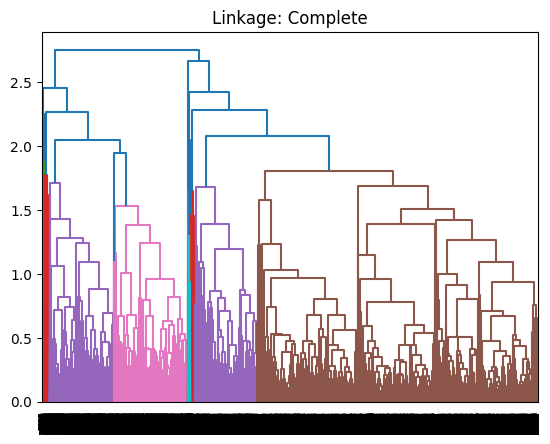

In [82]:
from sklearn.cluster import AgglomerativeClustering
ward_5 = AgglomerativeClustering(n_clusters=5, linkage="complete").fit(data_normalized)
print(ward_5.n_clusters_)

5


In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_trans = pca.fit_transform(data_normalized)

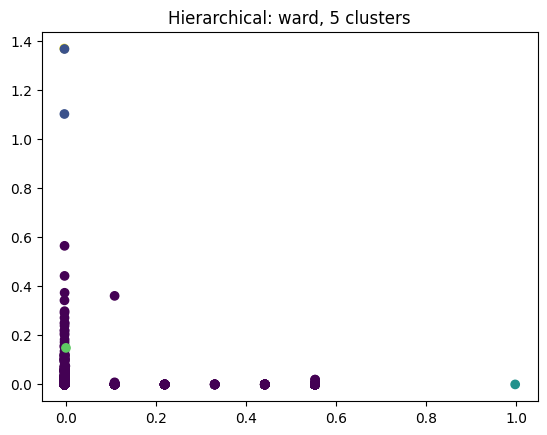

In [84]:
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=ward_5.labels_)
plt.title("Hierarchical: ward, 5 clusters")
plt.show()

In [86]:
from sklearn.metrics import silhouette_score
print("Agglomerative\t", silhouette_score(data_normalized, ward_5.labels_))

Agglomerative	 0.9887836955376494


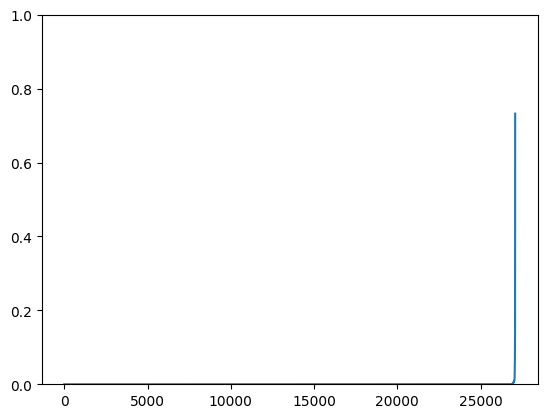

In [87]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=52).fit(data_normalized)
distances, indices = nbrs.kneighbors(data_normalized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=2, color='r', linestyle='--') #Ajuste el valor para y
plt.ylim(0, 1)
plt.plot(distances)

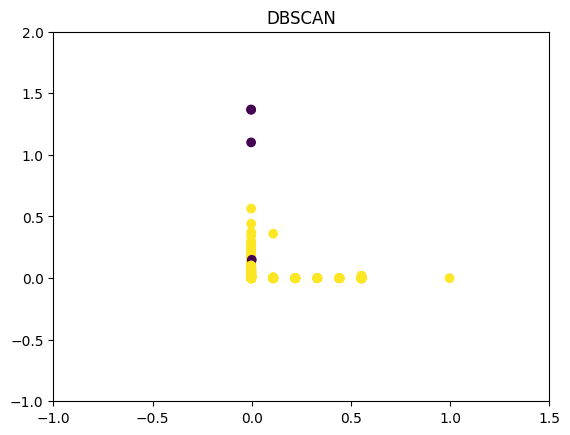

El numero de clusters es: 2


In [88]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


dbscan_1 = DBSCAN(eps=0.5, min_samples=28)
dbs_fit = dbscan_1.fit(data_normalized)

plt.scatter(X_trans[:, 0], X_trans[:, 1], c=dbs_fit.labels_)
plt.title("DBSCAN")
plt.xlim(-1, 1.5)
plt.ylim(-1, 2)
plt.show()
print('El numero de clusters es: ' + str(len(np.unique(dbs_fit.labels_))))

In [89]:
# Use numpy.unique with return_counts
unique_elements, counts = np.unique(dbs_fit.labels_, return_counts=True)

print("Unique elements:", unique_elements)
print("Counts:", counts)

Unique elements: [-1  0]
Counts: [    4 27071]


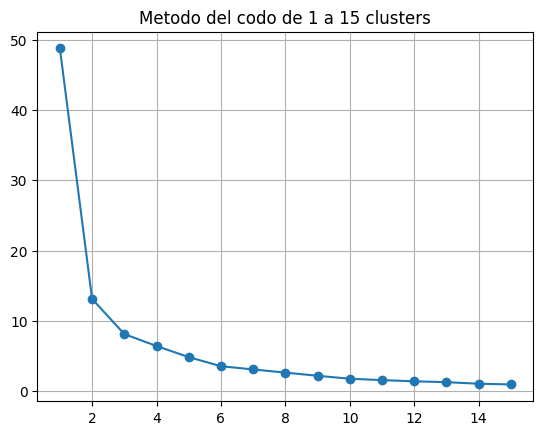

In [90]:
from sklearn.cluster import KMeans
sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(data_normalized)
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

In [91]:
kmeans_4 = KMeans(n_clusters=4).fit(data_normalized)

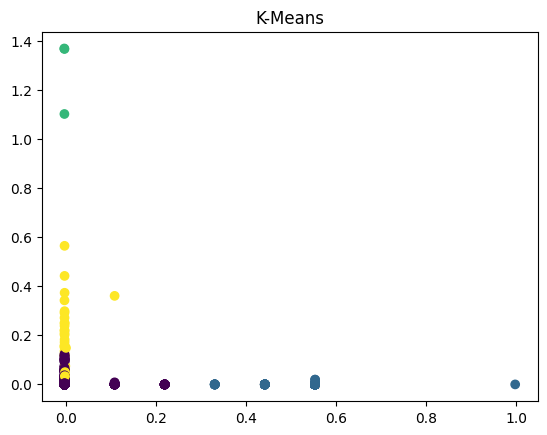

In [92]:
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=kmeans_4.labels_)
plt.title("K-Means")
plt.show()